# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import numpy as np

import torch.utils.data as data

from torch import nn

from sklearn.model_selection import train_test_split

from src.trainer.classification_trainer import ClassificationTrainer
from src.trainer.clustering_trainer import LabelPropagationTrainer
from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    PreProcessType,
    DimReductionType,
)
from src.data.indian_pines import load_indian_pines
from src.model.lenet import FullyConvolutionalLeNet
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_epoch_generic_comparison,
    plot_epoch_generic,
    plot_k_values,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.util.reporting import (
    create_model_name,
    report_run,
    read_report_to_show,
    classification_trainer,
)
from src.trainer.base_trainer import AdamOptimizedModule
from src.util.over_clustering import exponential_decay_over_clustering
from src.pipeline.common import KMeansClustering

2. Prepare env

In [2]:
learning_rate = 1e-3
num_epochs = 15
scheduler_step_size = num_epochs 
scheduler_gamma = 0.9
weight_decay = 0

lambda_v = 0.495
clusters_count = 20
k_star_multiplier = 3
semantic_threshold = 0.5
spatial_constraint_weights = [1, 0.5]
spatial_threshold = 8

In [3]:
batch_size = 33
patch_size = 9
target_dim = 75

pre_process_type = PreProcessType.NORMALIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [13]:
examples_per_class = [20] * num_classes

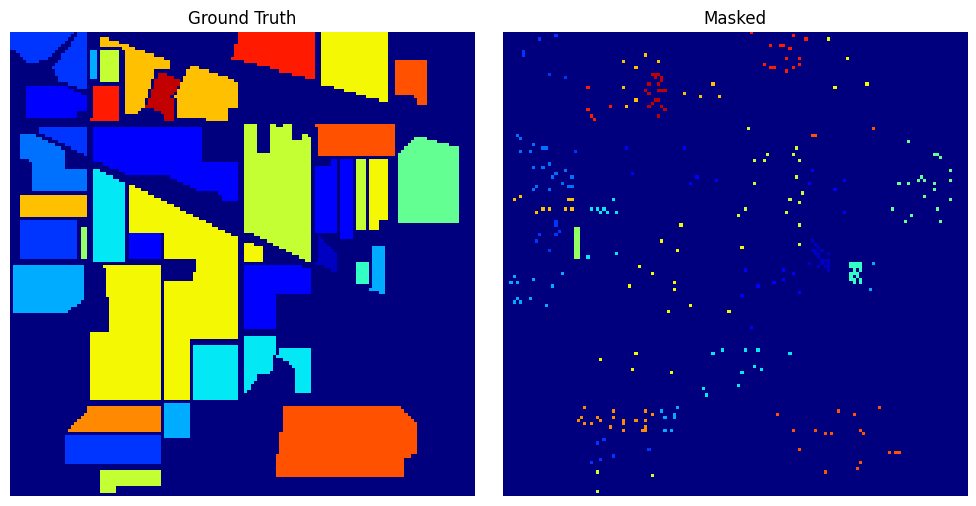

In [14]:
if examples_per_class:
    x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
        x, y, examples_per_class, "indian_pines"
    )

    plot_segmentation_comparison(
        y.reshape(image_h, image_w), y_masked.reshape(image_h, image_w), title2="Masked"
    )
else:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=random_seed, stratify=y
    )

# plot_numbers_distribution(y_train, desc="Train class distribution")

In [15]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [16]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
)

In [17]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

4. Train model

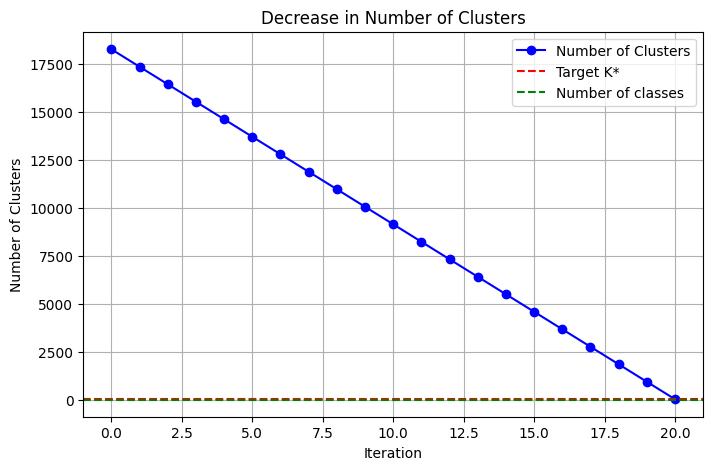

In [18]:
k_star = num_classes * k_star_multiplier

from src.util.over_clustering import linear_over_clustering

k_values = linear_over_clustering(
    max_cluster_size=18248, k_star=k_star, max_iter=clusters_count
)

# k_values = exponential_decay_over_clustering(
#     k_star=k_star, lambda_v=lambda_v, max_iter=clusters_count
# )

plot_k_values(k_values=k_values, k_star=k_star, num_classes=num_classes)

In [19]:
model = AdamOptimizedModule(
    FullyConvolutionalLeNet(target_dim, num_classes),
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler_step_size=scheduler_step_size,
    scheduler_gamma=scheduler_gamma,
)

loss = nn.CrossEntropyLoss()

base_trainer = ClassificationTrainer(
    num_epochs=1,
    num_classes=num_classes,
    criterion=loss,
    device=device,
    gradient_accumulation_steps=2,
)

clustering = KMeansClustering(seed=random_seed)

trainer = LabelPropagationTrainer(
    trainer=base_trainer,
    k_values=k_values,
    clustering=clustering,
    num_classes=num_classes,
    generator=generator,
    batch_size=batch_size,
    semantic_threshold=semantic_threshold,
    spatial_constraint_weights=spatial_constraint_weights,
    spatial_threshold=spatial_threshold,
)

In [20]:
feedback = trainer.fit(
    model, x.transpose(0, 3, 1, 2), y_masked.reshape(image_h, image_w), test_loader
)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 200, 1, 1])

In [ ]:
train_loss =  [it.history[-1].train["train_loss"] for it in feedback]
eval_loss = [it.history[-1].train["eval_loss"] for it in feedback]

plot_epoch_generic_comparison(train_loss, eval_loss)

# plot_epoch_generic(smothed_train)

In [ ]:
eval_f1 = [it.history[-1].train["eval_f1"] for it in feedback]

plot_epoch_generic(eval_f1)

In [ ]:
validation_result = base_trainer.validate(model, full_loader)

validation_result

5. Display prediction

In [ ]:
x.shape

In [ ]:
y_pred = model(x_tensor.to(device))

In [ ]:
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

In [ ]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.cpu().numpy(), num_classes)

6. Write report

In [ ]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "lenet_clustering"

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="More clusters, linear cluster count",
    run_params={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "patch_size": patch_size,
        "target_dim": target_dim,
        "lambda_v": lambda_v,
        "clusters_count": clusters_count,
        "k_star_multiplier": k_star_multiplier,
        "semantic_threshold": semantic_threshold,
        "spatial_constraint_weights": spatial_constraint_weights,
        "spatial_threshold": spatial_threshold,
        "scheduler_step_size": scheduler_step_size,
        "scheduler_gamma": scheduler_gamma,
        "pre_process_type": str(pre_process_type),
        "dim_reduction_type": str(dim_reduction_type),
    },
    run_metrics=classification_trainer(validation_result),
)

In [ ]:
read_report_to_show(model_name, sort_by_metric="f1")

In [ ]:
read_report_to_show(model_name, sort_by_metric="f1", model_category=model_category)